## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from plotnine import *

In [2]:
# Read in data set
ha = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [3]:
# Define X and y, plus pipelines
y = ha["diagnosis"]
X = ha[["age", "chol"]]

ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age", "chol"])
  ],
  remainder = "drop"
)


log_reg_pipeline = Pipeline([("logistic_regression", LogisticRegression(penalty="l2", random_state=42))]) # I left out the preprocessing ct because it was resulting in negative values for the step below

In [4]:
log_reg_pipeline_fitted = log_reg_pipeline.fit(X, y)

In [5]:
log_reg_intercept = log_reg_pipeline_fitted.named_steps["logistic_regression"].intercept_[0]
log_reg_age_coef, log_reg_chol_coef = log_reg_pipeline_fitted.named_steps["logistic_regression"].coef_[0]

chol_for_50_percent_chance = (0 - log_reg_intercept - (log_reg_age_coef * 55)) / log_reg_chol_coef
chol_for_90_percent_chance = ((np.log(0.9 / (1 - 0.9))) - log_reg_intercept - (log_reg_age_coef * 55)) / log_reg_chol_coef

print(f"For prediction of 'disease' (50% chance): {chol_for_50_percent_chance:.1f}")
print(f"For 90% chance of disease: {chol_for_90_percent_chance:.1f}")

For prediction of 'disease' (50% chance): 367.9
For 90% chance of disease: 1587.7
For prediction of 'disease' (50% chance): 367.9
For 90% chance of disease: 1587.7


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [6]:
lda_pipeline = Pipeline([("lda", LinearDiscriminantAnalysis())]) # I left out the preprocessing ct because it was resulting in negative values for the step below
lda_pipeline_fitted = lda_pipeline.fit(X, y)

In [16]:
lda_intercept = lda_pipeline_fitted.named_steps["lda"].intercept_[0]
lda_age_coef, lda_chol_coef = lda_pipeline.named_steps["lda"].coef_[0]
(-lda_intercept - (lda_age_coef * 55)) / lda_chol_coef

368.2353575299383

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [8]:
svc_pipeline = Pipeline([("svc", SVC(kernel="linear", random_state=42))])

param_grid = {"svc__C": [0.01, 0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring="roc_auc")
grid_search.fit(X, y)

grid_search.best_params_["svc__C"]

1000

In [ ]:
svc_pipeline = Pipeline([("svc", SVC(C=1000, kernel="linear", random_state=42))])
svc_pipeline_fitted = svc_pipeline.fit(X, y)

In [17]:
svc_intercept = svc_pipeline_fitted.named_steps["svc"].intercept_[0]
svc_age_coef, svc_chol_coef = svc_pipeline_fitted.named_steps["svc"].coef_[0]

-(svc_intercept + svc_age_coef * 55) / svc_chol_coef

312.7068849377974

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [18]:
plot_df = ha[["age", "chol", "diagnosis"]]

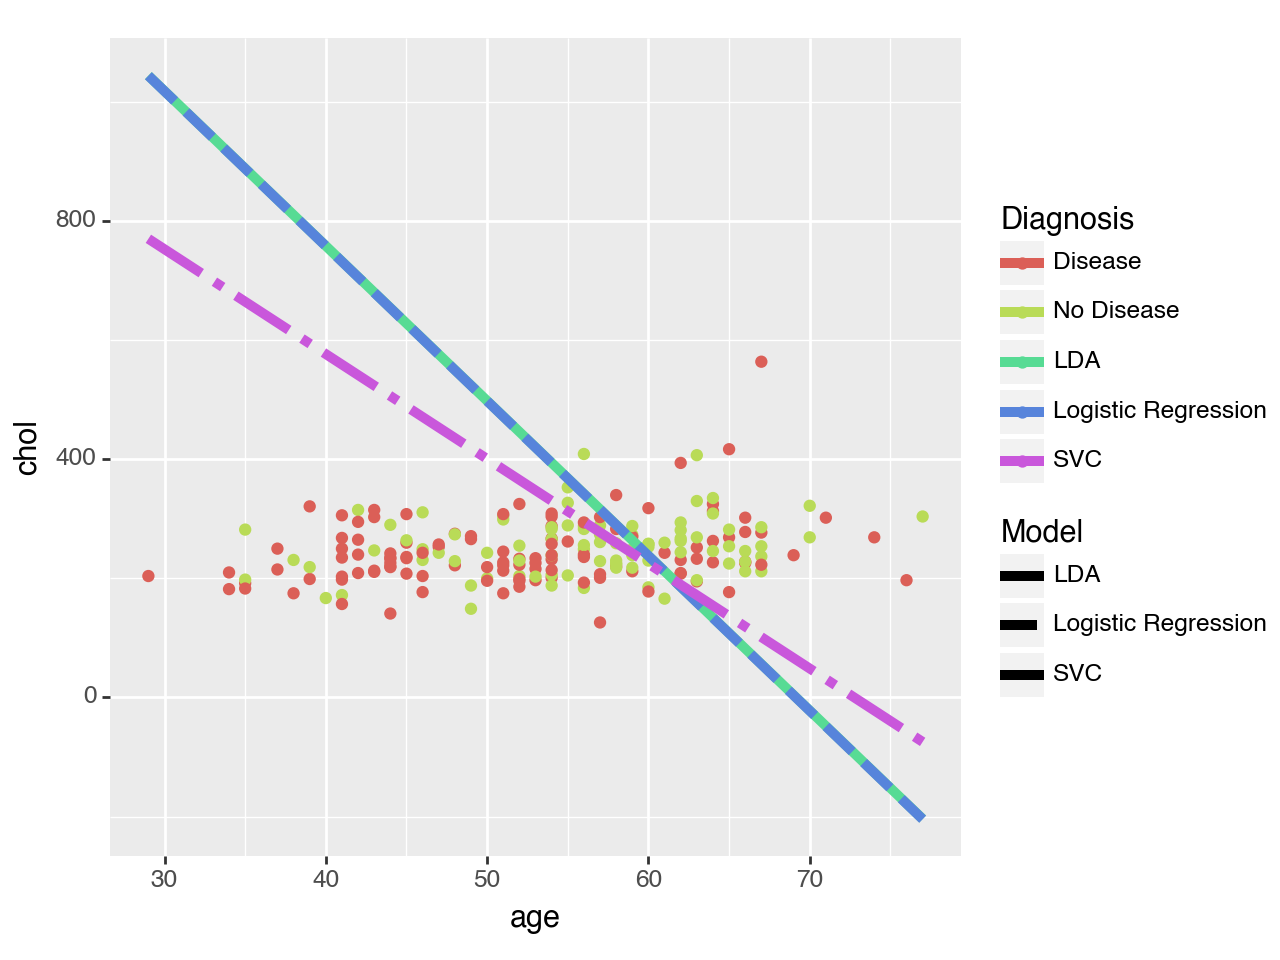

<Figure Size: (640 x 480)>

In [19]:
chol_log_reg = -(log_reg_intercept + log_reg_age_coef * ha["age"]) / log_reg_chol_coef
chol_lda = -(lda_intercept + lda_age_coef * ha["age"]) / lda_chol_coef
chol_svc = -(svc_intercept + svc_age_coef * ha["age"]) / svc_chol_coef

boundary_df = pd.DataFrame({
    "age": np.tile(ha["age"], 3),
    "chol": np.concatenate([chol_log_reg, chol_lda, chol_svc]),
    "model": np.repeat(["Logistic Regression", "LDA", "SVC"], len(ha["age"]))
})

boundary_df["diagnosis"] = None
plot_df_combined = pd.concat([plot_df, boundary_df], ignore_index=True)

(ggplot(plot_df,
aes(
    x="age",
    y="chol",
    color="diagnosis"
    ))
    + geom_point()
    + geom_line(boundary_df, aes(x="age", y="chol", color="model", linetype="model"), size=2)
    + labs(color="Diagnosis", linetype="Model"))